# Global spatial autocorrelation analysis for 2024 presidential election in Virginia

In [69]:
# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas
import pandas
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

import matplotlib.colors as mcolors

In [91]:
# The vote results are stored in a csv file which we read into a dataframe:
va_vote_data_path = "./2024_VA_County_Level_Presidential_Results.csv"
va_vote_df = pandas.read_csv(va_vote_data_path)


In [95]:
# Convert the county_fips code to a string
va_vote_df['county_fips'] = va_vote_df['county_fips'].astype("string")

In [96]:
# calculate the percentage of votes 
va_vote_df['per_gop'] = va_vote_df['per_gop']*100
va_vote_df['per_dem'] = va_vote_df['per_dem']*100
va_vote_df['per_point_diff'] = va_vote_df['per_point_diff']*100

In [98]:
# Read in the shapefile for Virginia counties
VA_Counties_gdf = geopandas.read_file(
    "./VA_Counties.json"
)

In [99]:
# Select only the columns we need
VA_Counties_gdf= VA_Counties_gdf[["US_Counties_20m_GEOID","geometry"]]

In [100]:
# Merge the two dataframes on the county_fips column
db = VA_Counties_gdf.merge(va_vote_df, left_on="US_Counties_20m_GEOID", right_on="county_fips", how="left")


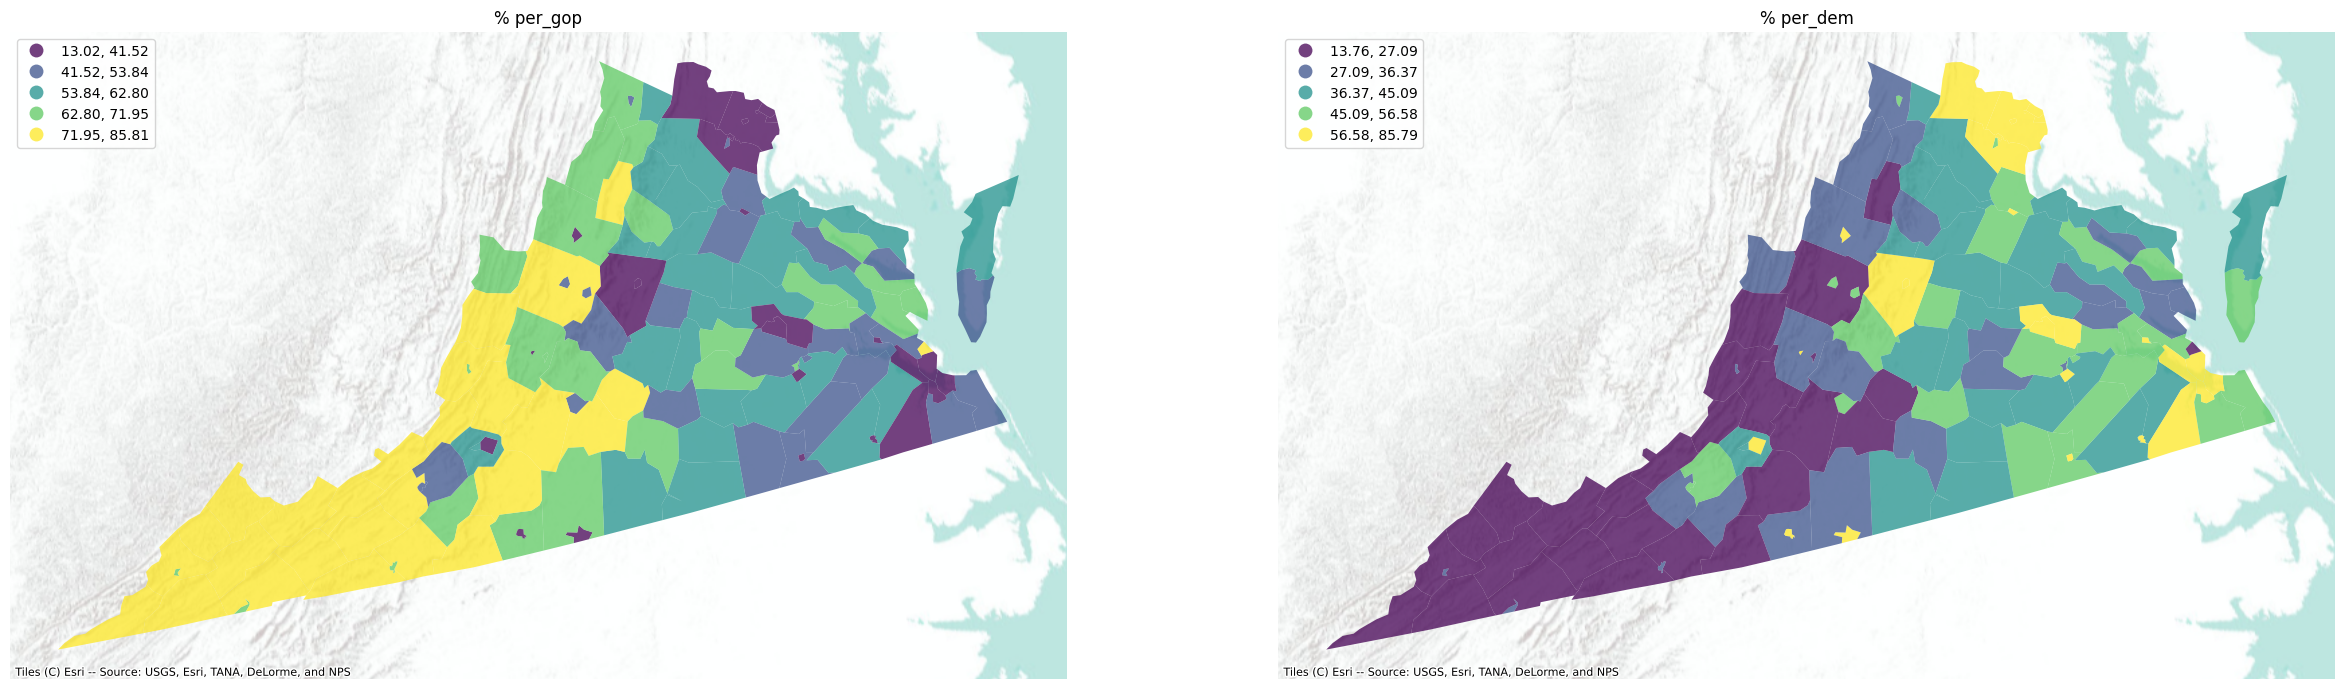

In [ ]:
# Plotting the results of the per_gop and per_dem
f, axs = plt.subplots(1, 2,figsize=(30, 15))
ax1, ax2 = axs
db.plot(
    column="per_gop",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax1,
)
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax1.set_title("% per_gop")
ax1.set_axis_off()

db.plot(
    column="per_dem",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax2,
)
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)
ax2.set_title("% per_dem")
ax2.set_axis_off()

In [102]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

In [116]:
# Calculate the spatial lag
db["per_gop_lag"] = weights.spatial_lag.lag_spatial(
    w, db["per_gop"]
)
db["per_dem_lag"] = weights.spatial_lag.lag_spatial(
    w, db["per_dem"]
)

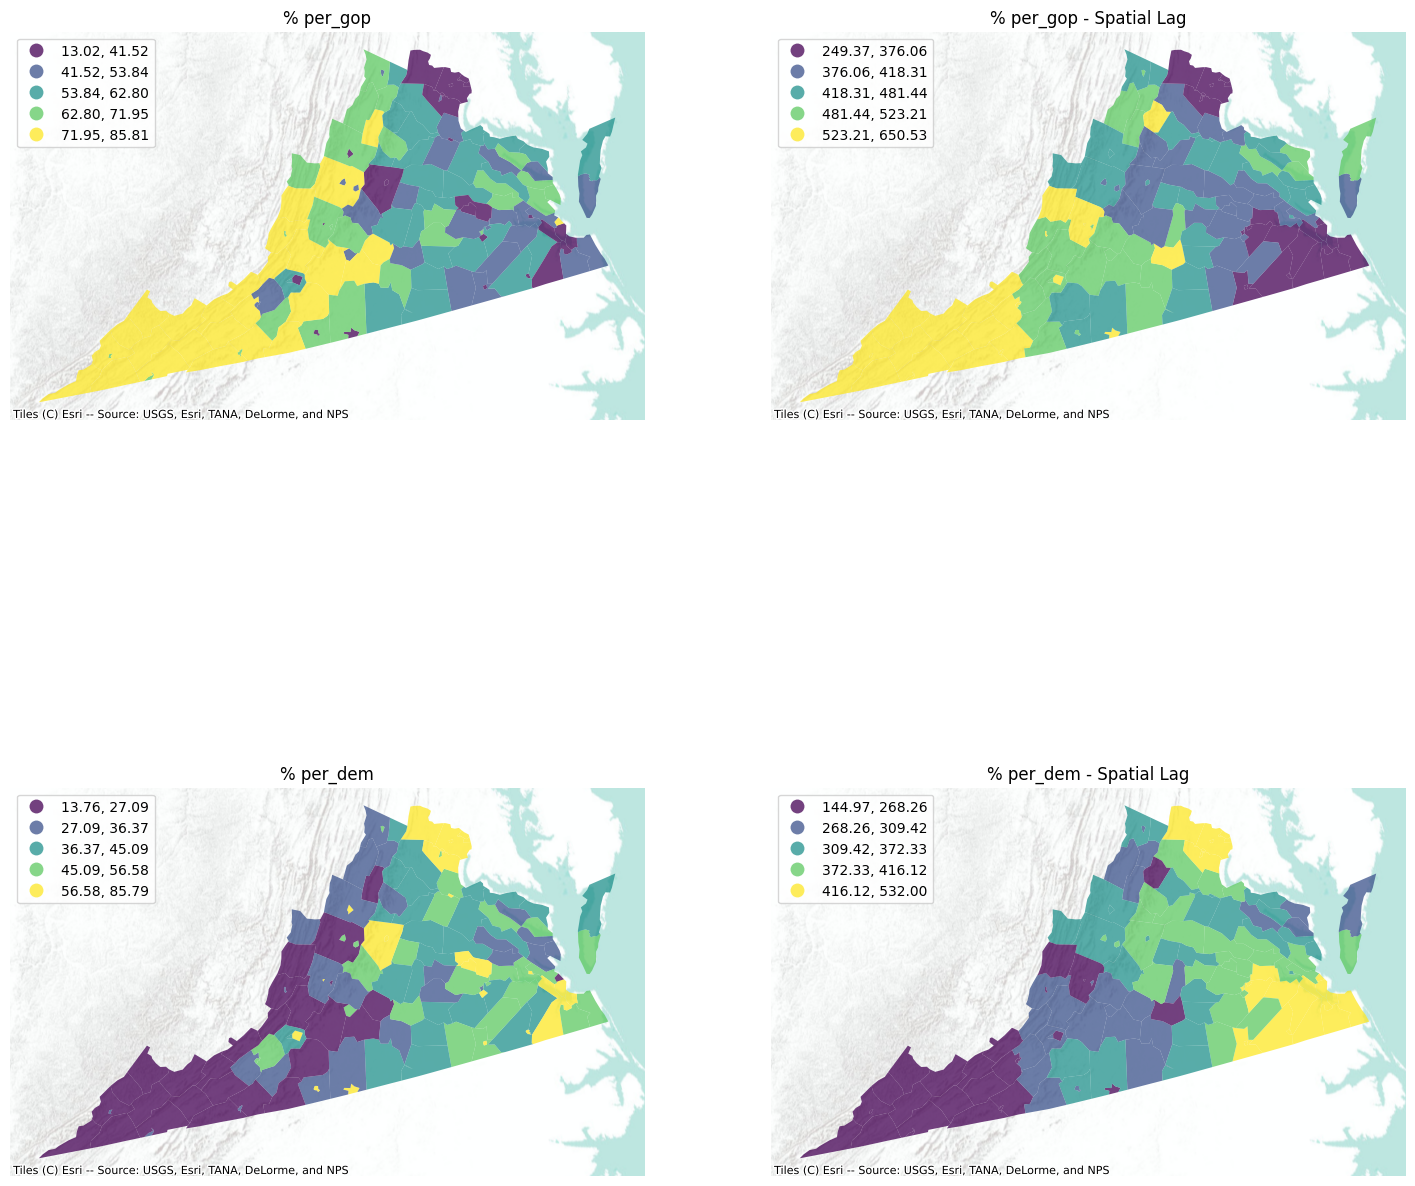

In [117]:
# Plotting the results of the percentage and the spatial lag
f, axs = plt.subplots(2, 2, figsize=(18, 18))
ax1, ax2, ax3, ax4 = axs.flatten()

db.plot(
    column="per_gop",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("% per_gop")
contextily.add_basemap(
    ax1,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="per_gop_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("% per_gop - Spatial Lag")
contextily.add_basemap(
    ax2,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="per_dem",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax3,
)
ax3.set_axis_off()
ax3.set_title("% per_dem")
contextily.add_basemap(
    ax3,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

db.plot(
    column="per_dem_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax4,
)
ax4.set_axis_off()
ax4.set_title("% per_dem - Spatial Lag")
contextily.add_basemap(
    ax4,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)


plt.show()

In [118]:
# calculate a binary variable (win_gop) that indicates 1 if gop wins, and zero otherwise
db["win_gop"] = (db["per_gop"] > db["per_dem"] ).astype(int)
db[["per_gop", "win_gop"]].tail()

,per_gop,win_gop
128,67.995718,1
129,48.809160,0
130,60.184133,1
131,38.087664,0
132,46.323587,0


In [119]:
# calculate a binary variable (win_dem) that indicates 1 if dem wins, and zero otherwise
db["win_dem"] = (db["per_dem"] > db["per_gop"] ).astype(int)
db[["per_dem", "win_dem"]].tail()

,per_dem,win_dem
128,30.948313,0
129,49.328244,1
130,38.883837,0
131,60.710498,1
132,52.546569,1


In [108]:
# add a column(win) and assign "gop" if win_gop == 1, and "dem" otherwise
db["win"] = db["win_gop"].apply(lambda x: "gop" if x == 1 else "dem")

# Plotting the results of vote winner

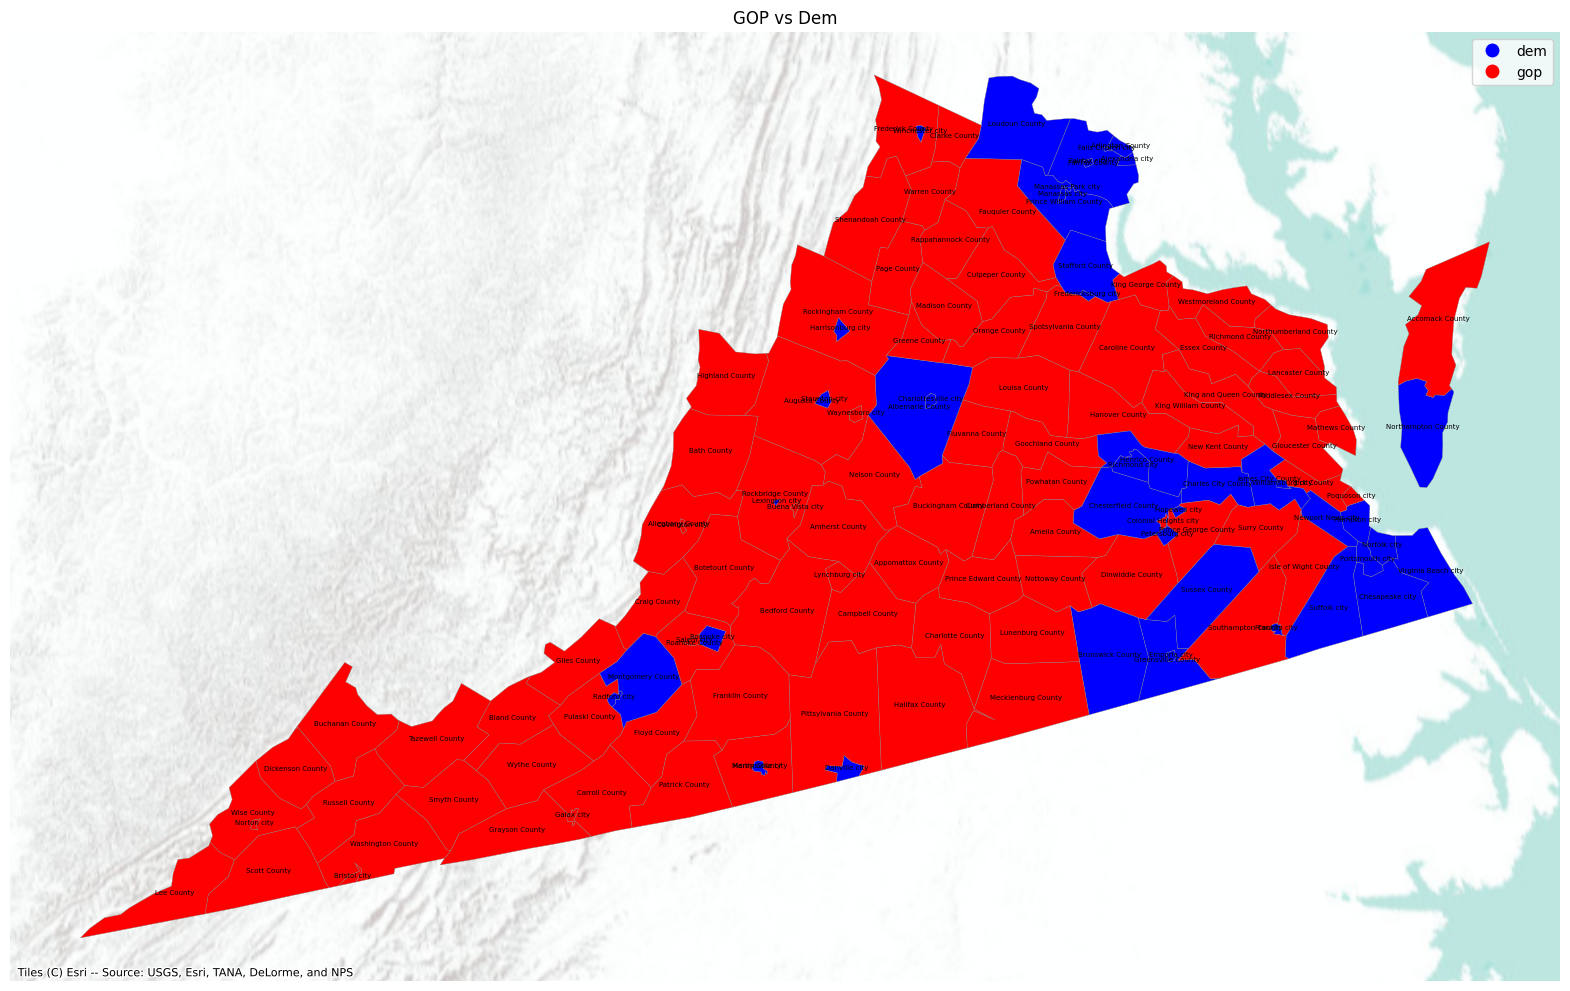

In [ ]:

cmap_gop = mcolors.ListedColormap(["blue", "red"])  # Blue for 0, Red for 1
bounds = [0, 0.5, 1]
norm = mcolors.BoundaryNorm(bounds, cmap_gop.N)
f, ax = plt.subplots(1, figsize=(20, 20))
db.plot(
    ax=ax,
    column="win",
    categorical=True,
    legend=True,
    edgecolor="0.5",
    linewidth=0.25,
    cmap=cmap_gop,  # Use custom colormap
    norm=norm,
)
ax.set_axis_off()
ax.set_title("GOP vs Dem")
#plt.axis("equal")
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.Esri.WorldTerrain,
)

# Label counties with 'win_gop' value of 1
for idx, row in db.iterrows():  # Filter rows where 'win_gop' == 1
    centroid = row.geometry.centroid
    county_name = row['county_name']  # Assuming county names are in a column named 'county_name'
    ax.text(centroid.x, centroid.y, county_name, fontsize=5, ha='center', color='black')
plt.show()

# Calculate the Moran's statistic 

In [121]:
# Calculate the Moran's statistic for the percentage of GOP votes
db["per_gop_std"] = db["per_gop"] - db["per_gop"].mean()
db["per_gop_lag_std"] = weights.lag_spatial(
    w, db["per_gop_std"]
)

In [124]:
# Calculate the Moran's statistic for the percentage of DEM votes
db["per_dem_std"] = db["per_dem"] - db["per_dem"].mean()
db["per_dem_lag_std"] = weights.lag_spatial(
    w, db["per_dem_std"]
)

# Create two Moran Plots

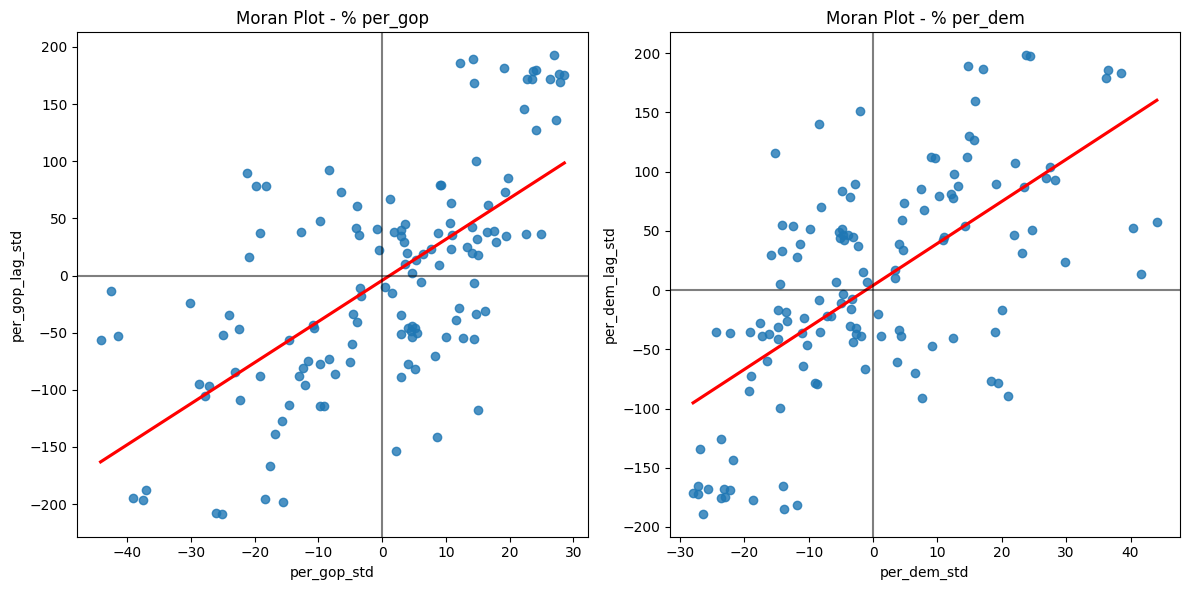

In [125]:


# Create a figure with 2 subplots (side by side)
f, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot 1 (Moran Plot - % per_gop)
seaborn.regplot(
    x="per_gop_std",
    y="per_gop_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
    ax=axs[0],  # Assign the first subplot
)
axs[0].axvline(0, c="k", alpha=0.5)
axs[0].axhline(0, c="k", alpha=0.5)
axs[0].set_title("Moran Plot - % per_gop")

# Plot 2 (Moran Plot - % per_dem)
seaborn.regplot(
    x="per_dem_std",
    y="per_dem_lag_std",
    ci=None,
    data=db,
    line_kws={"color": "r"},
    ax=axs[1],  # Assign the second subplot
)
axs[1].axvline(0, c="k", alpha=0.5)
axs[1].axhline(0, c="k", alpha=0.5)
axs[1].set_title("Moran Plot - % per_dem")

# Show the combined figure
plt.tight_layout()  # To adjust spacing between subplots
plt.show()


The figures above display the relationship between the standardized “party” voting percentage in a local authority and its spatial lag which can be interpreted as the average standardized density of the percent party vote in the neighborhood of each observation. In order to guide the interpretation of the plot, a linear fit is also included. This line represents the best linear fit to the scatter plot or, in other words, what is the best way to represent the relationship between the two variables as a straight line.

In [127]:
# standardize the w object 
w.transform = "R"
# calculate Moran’s I for per_gop
moran_gop = esda.moran.Moran(db["per_gop"], w)

In [128]:
# standardize the w object 
w.transform = "R"
# calculate Moran’s I for per_dem
moran_dem = esda.moran.Moran(db["per_dem"], w)

In [129]:
moran_gop.I

0.44916720841726904

In [79]:
moran_dem.I

0.4432868814954128

The other bit of information we will extract from Moran’s I relates to statistical inference: could the pattern we observe in the map (and that measured by Moran’s I) have arisen purely from randomness? If we considered the same variable but shuffled its locations randomly, would we obtain a map with similar characteristics? To obtain insight into these questions, esda performs a simulation and returns a measure of certainty about how likely it is to obtain a pattern like the one we observe under a spatially random process. This is summarized in the p_sim attribute:

In [80]:
moran_gop.p_sim

0.001

In [81]:
moran_dem.p_sim

0.001

The value is calculated as an empirical p-value that represents the proportion of realizations in the simulation under spatial randomness that are more extreme than the observed value. A small enough p-value associated with the Moran’s I of a map allows to reject the hypothesis that the map is random. In other words, we can conclude that the map displays more spatial pattern than we would expect if the values had been randomly allocated to a locations.

That is a very low value, particularly considering it is actually the minimum value we could have obtained given the simulation behind it used 999 permutations (default in esda) and, by standard terms, it would be deemed statistically significant. We can elaborate a bit further on the intuition behind the value of p_sim. If we generated a large number of maps with the same values but randomly allocated over space, and calculated the Moran’s I statistic for each of those maps, only 0.01% of them would display a larger (absolute) value than the one we obtain from the observed data, and the other 99.99% of the random maps would receive a smaller (absolute) value of Moran’s I. If we remember again that the value of Moran’s I can also be interpreted as the slope of the Moran Plot, what we have is that, in this case, the particular spatial arrangement of values over space we observe for the percentage of Leave votes is more concentrated than if we were to randomly shuffle the vote proportions among the map, hence the statistical significance. As a first step, the global autocorrelation analysis can teach us that observations do seem to be positively autocorrelated over space. Indeed, the overall spatial pattern in the EU Referendum vote was highly marked: nearby areas tended to vote alike.

Thanks to the splot visualization module in Pysal, we can obtain a quick representation of the statistic that combines the Moran scatterplot we saw before with a graphic of the empirical test that we carry out to obtain p_sim. This is shown in 

C:\Users\bsb5pw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


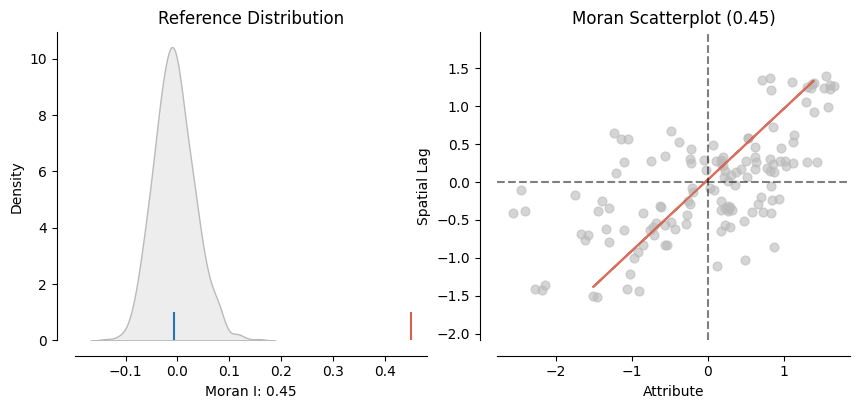

In [135]:
plot_moran(moran_gop);


On the left panel we can see in grey the empirical distribution generated from simulating 999 random maps with the values of the per_gop variable and then calculating Moran’s I for each of those maps. The blue rug signals the mean. In contrary, the red rug shows Moran’s I calculated for the variable using the geography observed in the dataset. It is clear the value under the observed pattern is significantly higher than under randomness. This insight is confirmed on the right panel, which shows an equivalent plot to the Moran Scatter plot we created above.

C:\Users\bsb5pw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


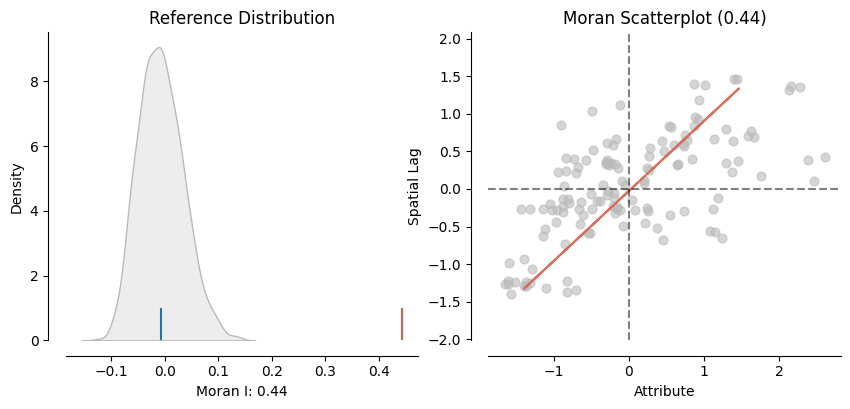

In [133]:
plot_moran(moran_dem);